In [35]:
import networkx as nx
import fast_model_improved as fmi
from pyexpat import model
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy

In [36]:
def create_network(network_type='random', num_nodes=1000, num_edges=0, prob=0.01):
    if network_type == 'random':
        G = nx.gnm_random_graph(num_nodes, num_edges)
    elif network_type == 'scale_free':
        G = nx.scale_free_graph(num_nodes)
    elif network_type == 'erdos_renyi':
        G = nx.erdos_renyi_graph(num_nodes, prob)
    elif network_type == 'preferential_attachment':
        G = nx.barabasi_albert_graph(num_nodes, 2)
    elif network_type == 'small_world':
        G = nx.watts_strogatz_graph(num_nodes, k=4, p=0.1)
    else:
        raise ValueError("Unsupported network type")
    return G

def choose_influencers(model, num_influencers, method='random'):
    if method == 'random':
        return model.random_influencers(num_influencers)
    elif method == 'hill_climbing':
        return model.greedy_hill_climbing(num_influencers, steps=10, R=10)
    else:
        raise ValueError("Unsupported method for selecting influencers")

def run_influence_cascade(graph, num_influencers, steps, selection_method='random'):

    # Initialize the model
    model = fmi.InfluenceDeinfluenceModel(graph, selection_method)
    
    # Choose influencers
    influencers = choose_influencers(model, num_influencers, method=selection_method)
    model.set_influencers(influencers)
    model.selected_influencers = influencers
    
    # Run the cascade
    model.run_cascade(steps)
    
    # Return the updated graph and model
    return model

def run_simple_cascade(steps):
    model.set_influencers(model.selected_influencers)
    model.run_cascade(steps)
    return model


In [37]:
# Define the combined count function
def count_deinfluenced(model, deinfluencers, num_runs, steps):
    total_deinfluenced = 0
    total_influenced = 0
    total_transition_counts = {'I->S': 0, 'D->S': 0, 'D->I': 0}
    
    # Create a deep copy of the model to ensure initial influencers remain the same
    initial_model = copy.deepcopy(model)
    
    for _ in range(num_runs):
        # Reset the model to the initial state with the same influencers
        model = copy.deepcopy(initial_model)
        model.reset_transition_counts()
        model.set_deinfluencers(deinfluencers)
        model.run_cascade(steps)
        
        total_deinfluenced += model.evaluate_deinfluence()
        total_influenced += model.evaluate_influence()
        
        for key in total_transition_counts:
            total_transition_counts[key] += model.transition_counts[key]
            
    return total_deinfluenced / num_runs, total_influenced / num_runs, {key: total / num_runs for key, total in total_transition_counts.items()}


In [38]:
G = create_network('preferential_attachment', 500)
model = run_influence_cascade(G, num_influencers=20, steps=3, selection_method='random')

# Evaluate the influence and deinfluence
num_influenced = model.evaluate_influence()
num_deinfluenced = model.evaluate_deinfluence()
num_susceptible = model.evaluate_susceptible()

# Create a deep copy of the model
model_fixed_influencers = copy.deepcopy(model)

In [39]:
def select_deinfluencers(k_deinfluencers_ls):
    deinfluencers_list = []
    
    for k in k_deinfluencers_ls:
        deinfluencers_dict = {}
        
        # Sample function calls to model object methods
        deinfluencers_dict['Random'] = model.select_deinfluencers_random(k)
        deinfluencers_dict['RanExIniInf'] = model.select_deinfluencers_from_not_ini_influencers(k)
        deinfluencers_dict['RanExAllInf'] = model.select_deinfluencers_from_not_influencers(k)
        deinfluencers_dict['Degree'] = model.select_deinfluencers_degree_centrality(k)
        deinfluencers_dict['Closeness'] = model.select_deinfluencers_closeness_centrality(k)
        deinfluencers_dict['Betweenness'] = model.select_deinfluencers_betweenness_centrality(k)
        deinfluencers_dict['Eigenvector'] = model.select_deinfluencers_eigenvector_centrality(k, max_iter=1000, tol=1e-06)
        deinfluencers_dict['PageRank'] = model.select_deinfluencers_pagerank_centrality(k)
        deinfluencers_dict['RIniInf'] = model.select_deinfluencers_from_ini_influencers(k)
        deinfluencers_dict['RInfl'] = model.select_deinfluencers_from_influencers(k)
        deinfluencers_dict['RRankedIniInf'] = model.select_deinfluencers_from_ini_influencers_degree_centrality(k)
        deinfluencers_dict['RRankedInf'] = model.select_deinfluencers_from_influencers_degree_centrality(k)
        
        deinfluencers_list.append((k, deinfluencers_dict))
    
    return deinfluencers_list

In [40]:
# Evaluate the influence and deinfluence
num_influenced = model_fixed_influencers.evaluate_influence()
num_deinfluenced = model_fixed_influencers.evaluate_deinfluence()
num_susceptible = model_fixed_influencers.evaluate_susceptible()

print(f"Number of influenced nodes: {num_influenced}")
print(f"Number of deinfluenced nodes: {num_deinfluenced}")
print(f"Number of susceptible nodes: {num_susceptible}")
print('influencer', model.selected_influencers)


Number of influenced nodes: 259
Number of deinfluenced nodes: 0
Number of susceptible nodes: 241
influencer {13, 406, 39, 296, 431, 177, 434, 306, 343, 346, 93, 226, 486, 360, 362, 113, 243, 117, 380, 125}


In [41]:
def average_results(deinfluencers_list, model, num_runs, steps):
    cumulative_results = {}

    for k, deinfluencers_methods in deinfluencers_list:
        if k not in cumulative_results:
            cumulative_results[k] = {method: (0, 0, {'I->S': 0, 'D->S': 0, 'D->I': 0}) for method in deinfluencers_methods.keys()}
        
        for _ in range(num_runs):
            results = {
                method: count_deinfluenced(model_fixed_influencers, deinfluencers, num_runs, steps)
                for method, deinfluencers in deinfluencers_methods.items()
            }
            
            for method, result in results.items():
                cumulative_results[k][method] = (
                    cumulative_results[k][method][0] + result[0],
                    cumulative_results[k][method][1] + result[1],
                    {key: cumulative_results[k][method][2][key] + result[2][key] for key in result[2]}
                )
    
    average_results = {
        k: {
            method: (
                cumulative_results[k][method][0] / num_runs,
                cumulative_results[k][method][1] / num_runs,
                {key: cumulative_results[k][method][2][key] / num_runs for key in cumulative_results[k][method][2]}
            )
            for method in cumulative_results[k]
        }
        for k in cumulative_results
    }
    
    return average_results


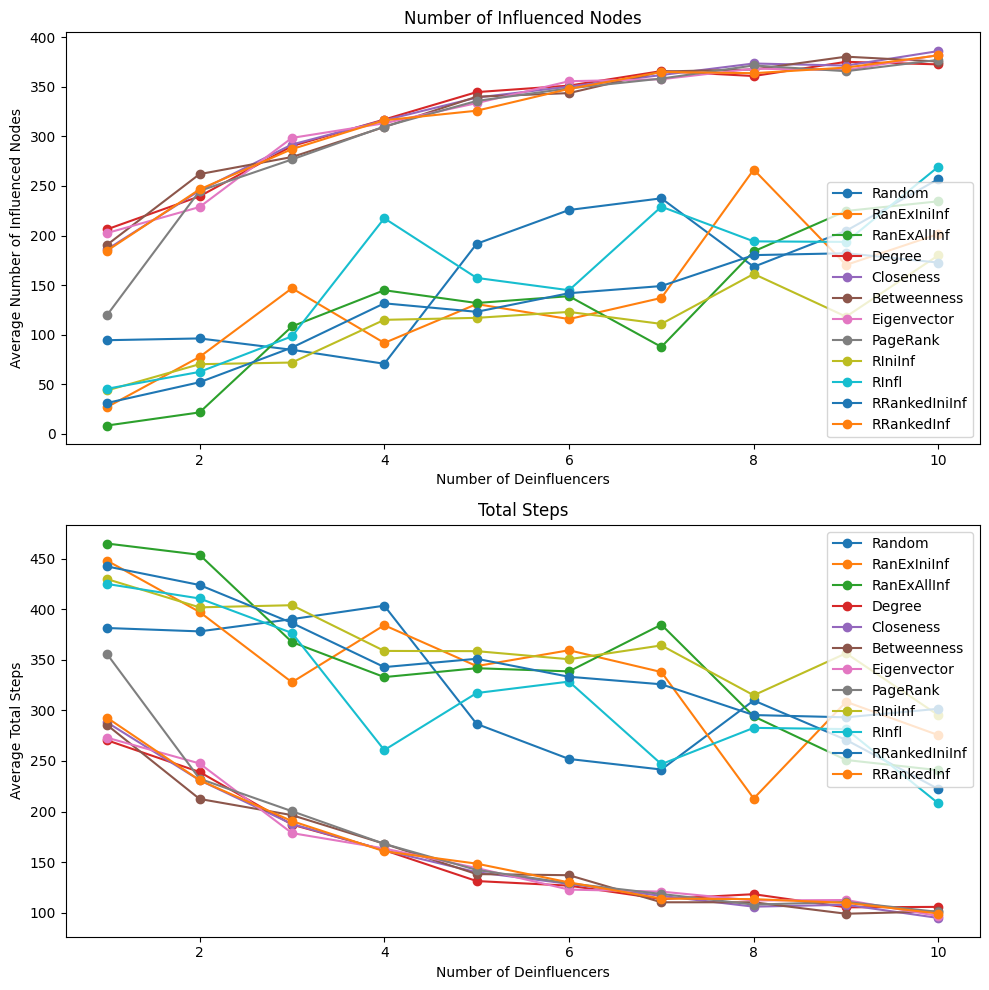

In [44]:
# Run simulation for different values of k
k_deinfluencers_ls = [1,2,3,4,5,6,7,8,9,10]  # Different values of k to test
deinfluencers_list = select_deinfluencers(k_deinfluencers_ls)
results = average_results(deinfluencers_list, model, num_runs=3, steps=3)

In [ ]:
# Define different marker styles for each method
marker_styles = {
    'Random': 'o',
    'RanExIniInf': 's',
    'RanExAllInf': 'D',
    'Degree': 'v',
    'Closeness': '^',
    'Betweenness': '<',
    'Eigenvector': '>',
    'PageRank': 'P',
    'RIniInf': '*',
    'RInfl': 'h',
    'RRankedIniInf': 'X',
    'RRankedInf': 'd'
}

# Plotting results
fig, axs = plt.subplots(3, figsize=(20, 20))
axs[0].set_title('Measured Deinfluence against Deinfluencer selection methods')
axs[1].set_title('Measured Influence against Deinfluencer selection methods')
axs[2].set_title('Measured Susceptible against Deinfluencer selection methods')

# Create line plots
methods = results[next(iter(results))].keys()  # Get all methods from the first key
k_values = sorted(results.keys())  # Sort k values for plotting

total_nodes = len(G.nodes)

for method in methods:
    deinfluenced_nodes = [results[k][method][0] for k in k_values]
    influenced_nodes = [results[k][method][1] for k in k_values]
    susceptible_nodes = [total_nodes - (influenced + deinfluenced) for influenced, deinfluenced in zip(influenced_nodes, deinfluenced_nodes)]

    marker = marker_styles.get(method, 'o')  # Default to 'o' if method is not in marker_styles

    axs[0].plot(k_values, deinfluenced_nodes, label=method, marker=marker)
    axs[1].plot(k_values, influenced_nodes, label=method, marker=marker)
    axs[2].plot(k_values, susceptible_nodes, label=method, marker=marker)

axs[0].legend()
axs[0].set_xlabel('Number of Deinfluencers')
axs[0].set_ylabel('Average Number of Deinfluenced Nodes')

axs[1].legend()
axs[1].set_xlabel('Number of Deinfluencers')
axs[1].set_ylabel('Average Number of Influenced Nodes')

axs[2].legend()
axs[2].set_xlabel('Number of Deinfluencers')
axs[2].set_ylabel('Average Number of Susceptible Nodes')

plt.tight_layout()
plt.show()
